<a href="https://colab.research.google.com/github/frantholy/Telecom_X2_ALURA/blob/main/telecomX2_ALURA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----------------------------------------------------------

## 📝 INTRODUCCIÓN CHALLENGE TELECOM X PARTE II - ALURA LATAM:

En esta parte 2 del proyecto se busca realizar un modelado predictivo para anticipar la cancelación de clientes en una empresa de telecomunicaciones. Buscando entender los factores que influyen en el abandono y proponer estrategias de retención efectivas.

-------------------------------

### IMPORTAR LIBRERIAS

In [ ]:
## Se importan las librerías esenciales.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from IPython.display import display, HTML
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

### CARGAR ARCHIVO Y CREAR DATASET

Cargamos el df tratado de la parte N°1 del Challenge Telecom X.

In [ ]:
## Importamos el df tratado.
url = "https://raw.githubusercontent.com/frantholy/Telecom_X2_ALURA/main/df_tratado.csv"
df = pd.read_csv(url)

# Verificar que se cargó correctamente
df.head()

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,PaperlessBilling,MonthlyCharges,TotalCharges,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,0,1,1,9,1,0,0,1,...,1,65.6,593.30,0,0,1,0,0,0,1
1,0,1,0,0,0,9,1,1,0,0,...,0,59.9,542.40,0,0,0,0,0,0,1
2,1,1,0,0,0,4,1,0,0,0,...,1,73.9,280.85,1,0,0,0,0,1,0
3,1,1,1,1,0,13,1,0,0,1,...,1,98.0,1237.85,1,0,0,0,0,1,0
4,1,0,1,1,0,3,1,0,0,0,...,1,83.9,267.40,1,0,0,0,0,0,1


In [ ]:
# Información general.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Churn                                  7032 non-null   int64  
 1   gender                                 7032 non-null   int64  
 2   SeniorCitizen                          7032 non-null   int64  
 3   Partner                                7032 non-null   int64  
 4   Dependents                             7032 non-null   int64  
 5   tenure                                 7032 non-null   int64  
 6   PhoneService                           7032 non-null   int64  
 7   MultipleLines                          7032 non-null   int64  
 8   OnlineSecurity                         7032 non-null   int64  
 9   OnlineBackup                           7032 non-null   int64  
 10  DeviceProtection                       7032 non-null   int64  
 11  Tech

### DISTRIBUCIÓN DE VARIABLE OBJETIVO

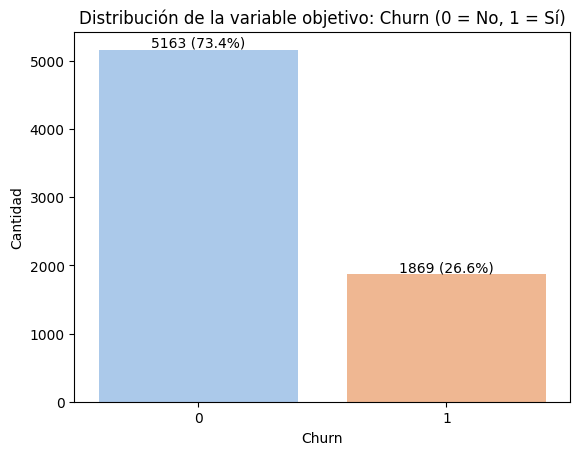

In [ ]:
# Crear gráfico
ax = sns.countplot(x='Churn', data=df, palette='pastel')

# Calcular totales
total = len(df)

# Agregar título y etiquetas
plt.title('Distribución de la variable objetivo: Churn (0 = No, 1 = Sí)')
plt.xlabel('Churn')
plt.ylabel('Cantidad')

# Agregar etiquetas de conteo + porcentaje
for container in ax.containers:
    ax.bar_label(container, labels=[
        f'{int(c.get_height())} ({c.get_height()/total:.1%})'
        for c in container
    ])

plt.show()

🔍 **Análisis de distribución de la variable objetivo:**

La variable objtivo se encuentra desbalanceada, esto podría afectar al rendimiento de los modelos, es por esto que es bueno considerar técnicas de balanceo como SMOTE antes de entrenar.

* Aproximadamente el **73.4%** de los clientes NO renuncian **(Churn = 0)**.
* Aproximadamente el **26.6%** sí renuncia **(Churn = 1)**.

### ESCALAR VARIABLES NÚMERICAS

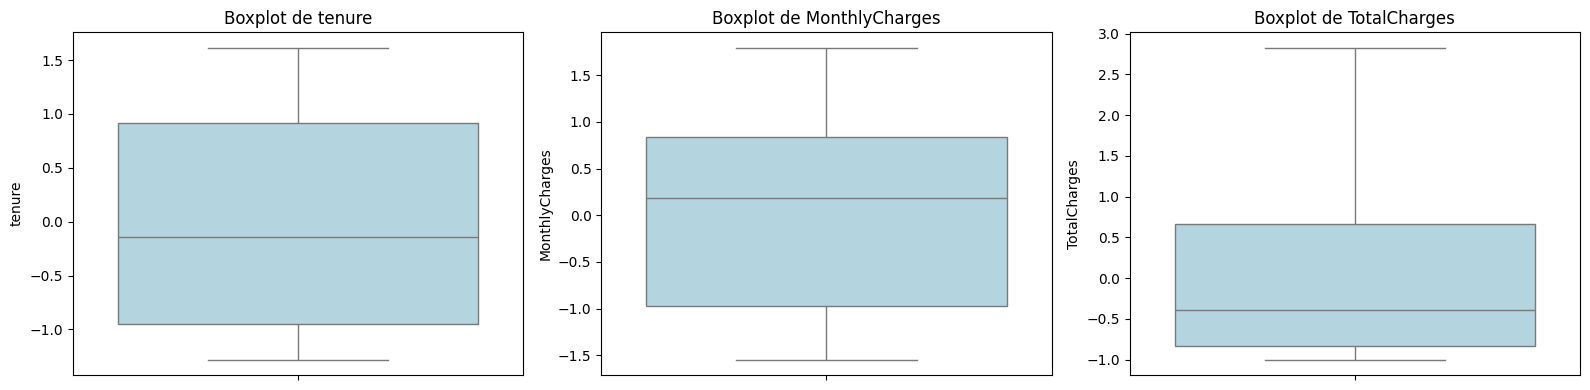

In [ ]:
# Columnas numéricas a escalar
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Instanciar el escalador
scaler = StandardScaler()

# Ajustar y transformar
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Detección de outliers con boxplots.
plt.figure(figsize=(16, 4))
for i, col in enumerate(['tenure', 'MonthlyCharges', 'TotalCharges']):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=df[col], color='lightblue')
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

### DIVIDIR DATOS EN CONJUNTOS DE ENTRENAMIENTO Y DE PRUEBA

In [ ]:
# Variables independientes (features)
X = df.drop('Churn', axis=1)

# Variable dependiente (target)
y = df['Churn']

# División 80/20 con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Verificación.
print(f"Tamaño total: {X.shape}")
print(f"Tamaño entrenamiento: {X_train.shape}")
print(f"Tamaño prueba: {X_test.shape}")

Tamaño total: (7032, 23)
Tamaño entrenamiento: (5625, 23)
Tamaño prueba: (1407, 23)


### BALANCEAMOS CON SMOTE

In [ ]:
# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Verificamos balance
display(HTML(f"<h5><b> Distribución después de SMOTE: </b></h5>"))
print(y_train_sm.value_counts())

0    4130
1    4130
Name: Churn, dtype: int64


### MODELO N°1: REGRESIÓN LOGÍSTICA

In [ ]:
# Instanciar GridSearchCV para Regresión Logística
# -----------------------------
log_model = LogisticRegression(max_iter=1000)

log_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

log_grid = GridSearchCV(log_model, log_params, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar con datos balanceados
log_grid.fit(X_train_sm, y_train_sm)

# -----------------------------
# Resultados del GridSearch
# -----------------------------
print("📌 Mejores hiperparámetros (Regresión Logística):")
print(log_grid.best_params_)

print("\n✅ Puntaje promedio en validación cruzada (CV):")
print(f"{log_grid.best_score_:.4f}")

# -----------------------------
# Evaluación en conjunto de prueba
# -----------------------------
y_pred = log_grid.predict(X_test)

print("\n🧪 Precisión en el conjunto de prueba:")
print(f"{log_grid.score(X_test, y_test):.4f}")

print("\n📊 Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\n📄 Reporte de clasificación:")
print(classification_report(y_test, y_pred))

📌 Mejores hiperparámetros (Regresión Logística):
{'C': 10, 'solver': 'lbfgs'}

✅ Puntaje promedio en validación cruzada (CV):
0.8021

🧪 Precisión en el conjunto de prueba:
0.7676

📊 Matriz de confusión:
[[799 234]
 [ 93 281]]

📄 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1033
           1       0.55      0.75      0.63       374

    accuracy                           0.77      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.77      0.78      1407



### MODELO N°2: KNN

In [ ]:
# Instanciar GridSearchCV para KNN
# -----------------------------
knn_model = KNeighborsClassifier()

knn_params = {
    'n_neighbors': list(range(3, 21, 2)),  # valores impares
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_grid = GridSearchCV(knn_model, knn_params, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar con datos balanceados
knn_grid.fit(X_train_sm, y_train_sm)

# -----------------------------
# Resultados del GridSearch
# -----------------------------
print("📌 Mejores hiperparámetros (KNN):")
print(knn_grid.best_params_)

print("\n✅ Puntaje promedio en validación cruzada (CV):")
print(f"{knn_grid.best_score_:.4f}")

# -----------------------------
# Evaluación en conjunto de prueba
# -----------------------------
y_pred = knn_grid.predict(X_test)

print("\n🧪 Precisión en el conjunto de prueba:")
print(f"{knn_grid.score(X_test, y_test):.4f}")

print("\n📊 Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\n📄 Reporte de clasificación:")
print(classification_report(y_test, y_pred))

📌 Mejores hiperparámetros (KNN):
{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

✅ Puntaje promedio en validación cruzada (CV):
0.8167

🧪 Precisión en el conjunto de prueba:
0.7143

📊 Matriz de confusión:
[[766 267]
 [135 239]]

📄 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.85      0.74      0.79      1033
           1       0.47      0.64      0.54       374

    accuracy                           0.71      1407
   macro avg       0.66      0.69      0.67      1407
weighted avg       0.75      0.71      0.73      1407



### MODELO N°3: ÁRBOL DE DECISIÓN

In [ ]:
# -----------------------------
# Instanciar GridSearchCV para Árbol de Decisión
# -----------------------------
tree_model = DecisionTreeClassifier(random_state=42)

tree_params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

tree_grid = GridSearchCV(tree_model, tree_params, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar con datos balanceados
tree_grid.fit(X_train_sm, y_train_sm)

# -----------------------------
# Resultados del GridSearch
# -----------------------------
print("📌 Mejores hiperparámetros (Árbol de Decisión):")
print(tree_grid.best_params_)

print("\n✅ Puntaje promedio en validación cruzada (CV):")
print(f"{tree_grid.best_score_:.4f}")

# -----------------------------
# Evaluación en conjunto de prueba
# -----------------------------
y_pred = tree_grid.predict(X_test)

print("\n🧪 Precisión en el conjunto de prueba:")
print(f"{tree_grid.score(X_test, y_test):.4f}")

print("\n📊 Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\n📄 Reporte de clasificación:")
print(classification_report(y_test, y_pred))

📌 Mejores hiperparámetros (Árbol de Decisión):
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}

✅ Puntaje promedio en validación cruzada (CV):
0.7827

🧪 Precisión en el conjunto de prueba:
0.7249

📊 Matriz de confusión:
[[750 283]
 [104 270]]

📄 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.73      0.79      1033
           1       0.49      0.72      0.58       374

    accuracy                           0.72      1407
   macro avg       0.68      0.72      0.69      1407
weighted avg       0.77      0.72      0.74      1407



### MODELO N°4: SVM

In [ ]:
# Instanciar GridSearchCV para SVM
# -----------------------------
svm = SVC(probability=True, random_state=42)

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Usamos F1 como métrica principal, ya que el dataset era desbalanceado
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='f1', n_jobs=-1)

# Ajustar con datos balanceados
grid_svm.fit(X_train_sm, y_train_sm)

# -----------------------------
# Resultados del GridSearch
# -----------------------------
print("📌 Mejor combinación de hiperparámetros (SVM):", grid_svm.best_params_)

print("\n✅ Puntaje promedio en validación cruzada (CV):")
print(f"{grid_svm.best_score_:.4f}")

# -----------------------------
# Evaluación en conjunto de prueba
# -----------------------------
y_pred = grid_svm.predict(X_test)

print("\n🧪 Precisión en el conjunto de prueba:")
print(f"{grid_svm.score(X_test, y_test):.4f}")

print("\n📊 Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\n📄 Reporte de clasificación:")
print(classification_report(y_test, y_pred))

📌 Mejor combinación de hiperparámetros (SVM): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

✅ Puntaje promedio en validación cruzada (CV):
0.8235

🧪 Precisión en el conjunto de prueba:
0.5960

📊 Matriz de confusión:
[[804 229]
 [118 256]]

📄 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.78      0.82      1033
           1       0.53      0.68      0.60       374

    accuracy                           0.75      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.75      0.76      1407



### COMPARAR CURVAS ROC DE LOS MODELOS

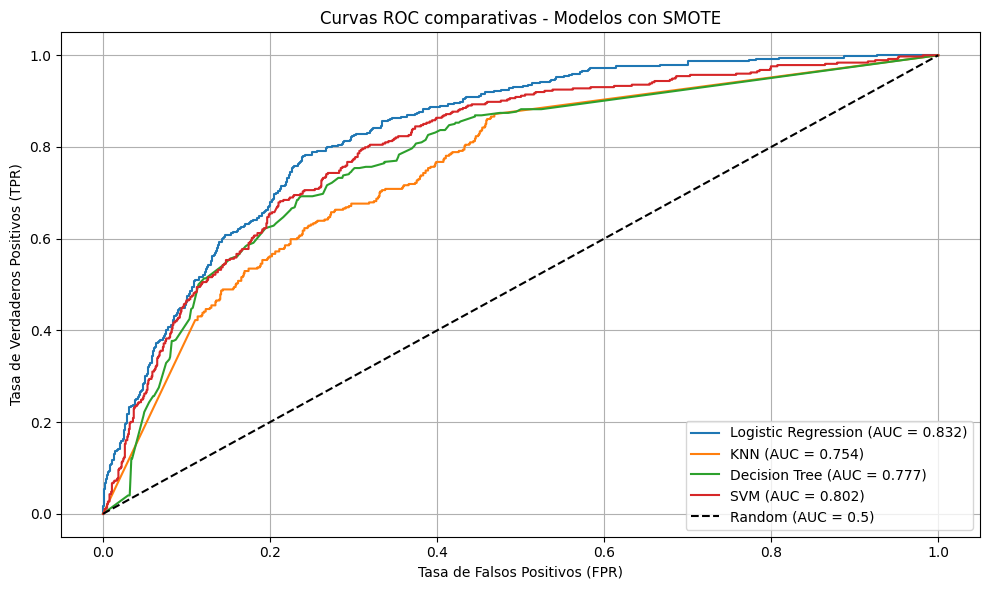

In [ ]:
# -----------------------------
# Obtener probabilidades de clase positiva (Churn = 1)
# -----------------------------
y_proba_log = log_grid.predict_proba(X_test)[:, 1]
y_proba_knn = knn_grid.predict_proba(X_test)[:, 1]
y_proba_tree = tree_grid.predict_proba(X_test)[:, 1]
y_proba_svm = grid_svm.predict_proba(X_test)[:, 1]

# -----------------------------
# Calcular curvas ROC
# -----------------------------
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_proba_tree)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)

# -----------------------------
# Calcular AUC
# -----------------------------
auc_log = roc_auc_score(y_test, y_proba_log)
auc_knn = roc_auc_score(y_test, y_proba_knn)
auc_tree = roc_auc_score(y_test, y_proba_tree)
auc_svm = roc_auc_score(y_test, y_proba_svm)

# -----------------------------
# Graficar curvas ROC
# -----------------------------
plt.figure(figsize=(10,6))

plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.3f})")
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {auc_knn:.3f})")
plt.plot(fpr_tree, tpr_tree, label=f"Decision Tree (AUC = {auc_tree:.3f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.3f})")

# Línea base (azar)
plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 0.5)")

# Etiquetas y título
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curvas ROC comparativas - Modelos con SMOTE")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### COMPARAR MÉTRICAS DE LOS MODELOS

,Modelo,Accuracy,Precision,Recall,F1 Score,AUC-ROC
0,Regresión Logística,0.7676,0.5456,0.7513,0.6322,0.8323
1,KNN,0.7143,0.4723,0.6390,0.5432,0.7538
2,Árbol de Decisión,0.7249,0.4882,0.7219,0.5825,0.7773
3,SVM,0.7534,0.5278,0.6845,0.5960,0.8024


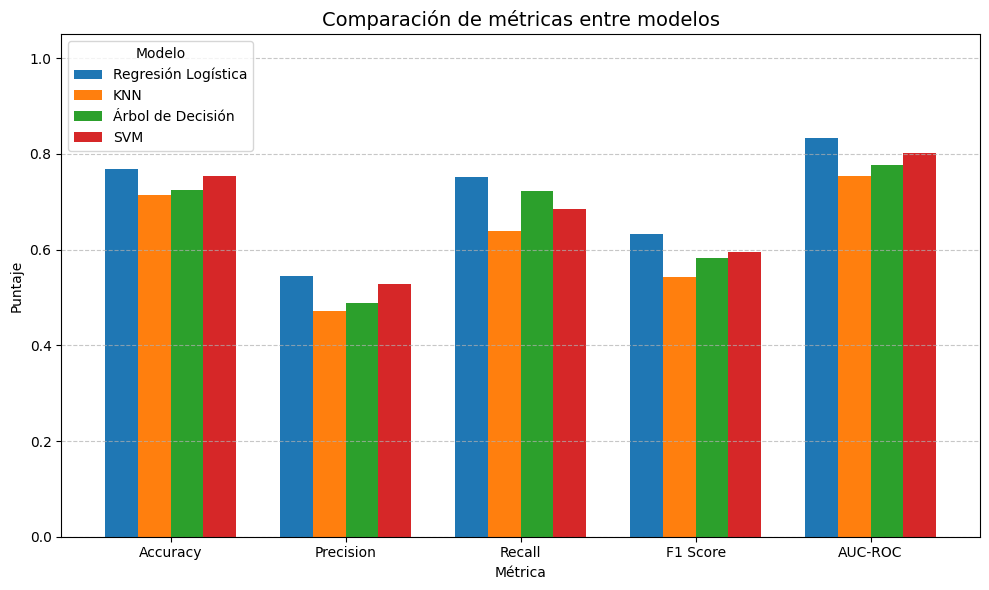

In [ ]:
# -----------------------------
# Predicciones (clase) de cada modelo
# -----------------------------
y_pred_log = log_grid.predict(X_test)
y_pred_knn = knn_grid.predict(X_test)
y_pred_tree = tree_grid.predict(X_test)
y_pred_svm = grid_svm.predict(X_test)

# -----------------------------
# Probabilidades (para AUC-ROC)
# -----------------------------
y_proba_log = log_grid.predict_proba(X_test)[:, 1]
y_proba_knn = knn_grid.predict_proba(X_test)[:, 1]
y_proba_tree = tree_grid.predict_proba(X_test)[:, 1]
y_proba_svm = grid_svm.predict_proba(X_test)[:, 1]

# -----------------------------
# Diccionario de métricas
# -----------------------------
metricas = {
    'Modelo': ['Regresión Logística', 'KNN', 'Árbol de Decisión', 'SVM'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_tree),
        accuracy_score(y_test, y_pred_svm)
    ],
    'Precision': [
        precision_score(y_test, y_pred_log),
        precision_score(y_test, y_pred_knn),
        precision_score(y_test, y_pred_tree),
        precision_score(y_test, y_pred_svm)
    ],
    'Recall': [
        recall_score(y_test, y_pred_log),
        recall_score(y_test, y_pred_knn),
        recall_score(y_test, y_pred_tree),
        recall_score(y_test, y_pred_svm)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_log),
        f1_score(y_test, y_pred_knn),
        f1_score(y_test, y_pred_tree),
        f1_score(y_test, y_pred_svm)
    ],
    'AUC-ROC': [
        roc_auc_score(y_test, y_proba_log),
        roc_auc_score(y_test, y_proba_knn),
        roc_auc_score(y_test, y_proba_tree),
        roc_auc_score(y_test, y_proba_svm)
    ]
}

# -----------------------------
# Crear DataFrame y mostrar tabla
# -----------------------------
df_metricas = pd.DataFrame(metricas)

display(HTML("<h3>📊 Comparación de Modelos</h3>"))
display(
    df_metricas.style
    .format({
        'Accuracy': '{:.4f}',
        'Precision': '{:.4f}',
        'Recall': '{:.4f}',
        'F1 Score': '{:.4f}',
        'AUC-ROC': '{:.4f}'
    })
    .set_table_styles([
        {'selector': 'th', 'props': [('font-weight', 'bold')]}
    ])
)

# -----------------------------
# Gráfico comparativo
# -----------------------------
df_plot = df_metricas.set_index('Modelo').T

ax = df_plot.plot(kind='bar', figsize=(10, 6), width=0.75)
plt.title('Comparación de métricas entre modelos', fontsize=14)
plt.ylabel('Puntaje')
plt.xlabel('Métrica')
plt.xticks(rotation=0)
plt.ylim(0, 1.05)
plt.legend(title='Modelo')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 📊 Análisis de Resultados

### **Accuracy (Exactitud)**
- **Mayor valor:** Regresión Logística (0.7676), seguida muy de cerca por SVM (0.7534).
- **Peor desempeño:** KNN (0.7143), posiblemente debido a su sensibilidad al ruido y la alta dimensionalidad.

### **Precision**
- Ningún modelo supera el 0.55, lo que indica una cantidad considerable de **falsos positivos**.
- **Mejores:** Regresión Logística (0.5456) y SVM (0.5278).
- KNN y Árbol de Decisión muestran valores más bajos.

### **Recall (Sensibilidad)**
- **Mejores:** Regresión Logística (0.7513) y Árbol de Decisión (0.7219).
- **Más bajo:** KNN (0.6390).
- Esto indica que RL y Árbol detectan más casos positivos correctamente.

### **F1-Score** *(balance entre Precision y Recall)*
- **Mejor balance:** Regresión Logística (0.6322), seguida por Árbol y SVM (~0.59).
- **Más bajo:** KNN (0.5432).

### **AUC-ROC** *(capacidad de discriminar entre clases)*
- **Líder:** Regresión Logística (0.8323), seguida por SVM (0.8024).
- Árbol (0.7773) y KNN (0.7538) tienen menor capacidad discriminativa.
- Confirma que RL y SVM son más consistentes al distinguir positivos de negativos.

---

## 💡 Conclusión
- **Regresión Logística** es el modelo más equilibrado y con mejor rendimiento global en todas las métricas.
- **SVM** es un segundo lugar sólido, especialmente en **AUC-ROC** y **Accuracy**.
- **Árbol de Decisión** destaca en Recall, pero con menor precisión, lo que implica más falsos positivos.
- **KNN** tiene el peor desempeño general, lo que sugiere dificultades para capturar la estructura de los datos, posiblemente por **alta dimensionalidad o ruido**.

### MEJOR MODELO: REGRESIÓN LOGÍSTICA

Utilizaremos este modelo para identificar a los 10 clientes con mayor probabilidad de renunciar.

In [ ]:
# Definir el modelo base
lr = LogisticRegression(random_state=42, max_iter=1000)

# Definir el grid de hiperparámetros
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

# Búsqueda de hiperparámetros
grid_lr = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')
grid_lr.fit(X_train, y_train)

# Guardar el mejor modelo
best_lr = grid_lr.best_estimator_

> ### TOP 10 CLIENTES CON MAYOR PROBABILIDAD DE RENUNCIAR

In [ ]:
# Obtener probabilidades de clase 1 (Churn = 1) para el conjunto de test
y_proba_test = best_lr.predict_proba(X_test)[:, 1]

# Crear DataFrame con los resultados
df_test_resultados = X_test.copy()
df_test_resultados['Churn_real'] = y_test
df_test_resultados['Probabilidad_Churn'] = y_proba_test

# Ordenar por mayor probabilidad de renuncia
top_10_clientes = df_test_resultados.sort_values(by='Probabilidad_Churn', ascending=False).head(10)

# Visualizar
display(HTML("<h4><b>Top 10 clientes con mayor probabilidad de renunciar (Modelo: Regresión Logística):</b></h4>"))
display(top_10_clientes.style.background_gradient(cmap='Reds', subset=['Probabilidad_Churn']))

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_real,Probabilidad_Churn
2798,0,1,0,0,-1.280248,1,0,0,0,0,0,1,1,1,0.880931,-0.967083,1,0,0,0,0,1,0,1,0.825761
3945,1,1,1,0,-1.198760,1,1,0,0,0,0,1,1,1,0.990625,-0.884030,1,0,0,0,0,1,0,1,0.824699
5778,0,0,0,0,-1.280248,1,1,0,0,0,0,1,1,1,0.965694,-0.965958,1,0,0,0,0,1,0,1,0.819719
3456,0,0,0,0,-1.280248,1,1,0,0,0,0,1,1,1,0.990625,-0.965627,1,0,0,0,0,1,0,1,0.819467
3845,1,0,0,0,-1.280248,1,1,0,0,1,0,1,1,1,1.218322,-0.962605,1,0,0,0,0,1,0,1,0.806455
4494,1,1,0,0,-1.158016,1,0,0,0,1,0,1,1,1,0.995611,-0.821006,1,0,0,0,0,1,0,0,0.803029
882,0,1,0,0,-1.158016,1,1,0,0,1,0,0,1,1,0.799492,-0.843043,1,0,0,0,0,1,0,1,0.802641
5271,1,1,0,0,-0.832064,1,1,0,0,1,0,1,1,1,1.151841,-0.477872,1,0,0,0,0,1,0,1,0.801375
4941,0,1,0,0,-0.954296,1,1,0,0,1,0,1,0,1,0.841043,-0.647002,1,0,0,0,0,1,0,0,0.801040
4617,1,0,0,1,-1.280248,1,1,0,0,0,0,1,1,1,0.947412,-0.966201,1,0,0,0,0,1,0,1,0.797978


> ### TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES DEL MODELO ESCOGIDO DE REGRESIÓN LOGÍSTICA

                           Feature  Importance
4                           tenure    1.319772
19               Contract_Two year    1.284978
17              InternetService_No    0.851248
16     InternetService_Fiber optic    0.801077
18               Contract_One year    0.705017
15                    TotalCharges    0.613126
10                     TechSupport    0.432112
5                     PhoneService    0.409722
13                PaperlessBilling    0.372282
21  PaymentMethod_Electronic check    0.360264


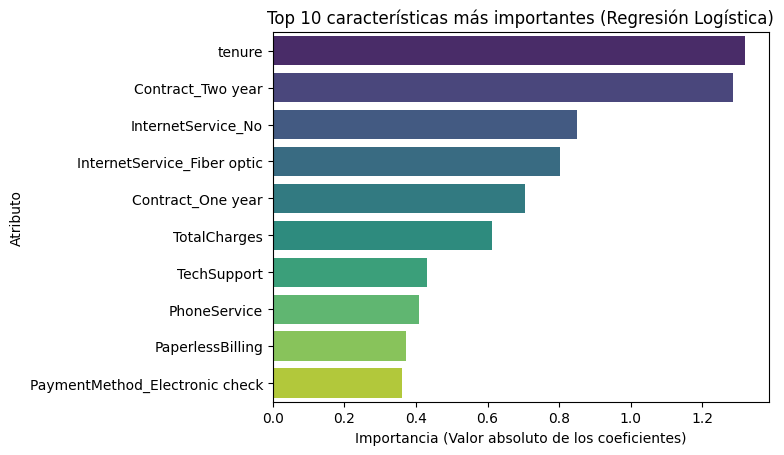

In [ ]:
# Obtener la importancia de cada atributo a partir de los coeficientes absolutos
importancias_lr = pd.DataFrame({
    'Feature': X.columns,
    'Importance': abs(best_lr.coef_[0])  # Valor absoluto de los coeficientes
}).sort_values(by='Importance', ascending=False)

# Seleccionar las 10 características más importantes
top10_lr = importancias_lr.head(10)

# Mostrar tabla de top 10 características
from IPython.display import display, HTML
display(HTML("<h5><b>Top 10 características más importantes (Regresión Logística):</b></h5>"))
print(top10_lr)

# Visualizar las 10 variables más importantes
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='Importance', y='Feature', data=top10_lr, palette='viridis')
plt.title('Top 10 características más importantes (Regresión Logística)')
plt.xlabel('Importancia (Valor absoluto de los coeficientes)')
plt.ylabel('Atributo')
plt.show()

> ### MENOR O MAYOR PROBABILIDAD DE CHURN POR CARACTERÍSTICAS

In [ ]:
# Crear DataFrame con signo de coeficientes
importancias_lr['Efecto'] = importancias_lr['Importance'] * np.sign(best_lr.coef_[0])
importancias_lr['Probabilidad_Churn'] = importancias_lr['Efecto'].apply(lambda x: 'Mayor' if x > 0 else 'Menor')

# Seleccionar top 10 características por importancia
top10_lr = importancias_lr.sort_values(by='Importance', ascending=False).head(10)

# Mostrar tabla sin índice
display(top10_lr[['Feature', 'Importance', 'Probabilidad_Churn']].style.hide_index())

Feature,Importance,Probabilidad_Churn
tenure,1.319772,Menor
Contract_Two year,1.284978,Mayor
InternetService_No,0.851248,Menor
InternetService_Fiber optic,0.801077,Menor
Contract_One year,0.705017,Menor
TotalCharges,0.613126,Menor
TechSupport,0.432112,Mayor
PhoneService,0.409722,Menor
PaperlessBilling,0.372282,Menor
PaymentMethod_Electronic check,0.360264,Menor


## 🔹 Observaciones generales:

- La columna **Importance** muestra qué tan relevante es cada característica para predecir churn según la regresión logística (coeficientes absolutos).  
- La columna **Probabilidad_Churn** indica si la característica aumenta (“Mayor”) o disminuye (“Menor”) la probabilidad de que un cliente se vaya.  


## 🔹 Insights por característica:

- **tenure (1.32, Menor):** Clientes con más tiempo de permanencia tienen menos probabilidad de churn. Es la característica más importante y protege contra la renuncia.

- **Contract_Two year (1.28, Mayor):** Tener un contrato de dos años aumenta la probabilidad de churn según el modelo.

- **InternetService_No (0.85, Menor):** Clientes sin servicio de Internet tienen menor probabilidad de churn.

- **InternetService_Fiber optic (0.80, Menor):** La red por fibra óptica es más estable, se asocia con menor churn.

- **Contract_One year (0.70, Menor):** Contratos de un año disminuyen el churn, al contrario del contrato de dos años.

- **TotalCharges (0.61, Menor):** Clientes con mayor gasto total tienden a quedarse más tiempo.

- **TechSupport (0.43, Mayor):** Tener soporte técnico se asocia con mayor churn. Podría indicar que quienes usan soporte tienen problemas recurrentes y podrían irse.

- **PhoneService (0.41, Menor):** Tener servicio de teléfono disminuye la probabilidad de churn.

- **PaperlessBilling (0.37, Menor):** Facturación electrónica se asocia con menor churn, aunque su importancia es baja.

- **PaymentMethod_Electronic check (0.36, Menor):** Usar cheque electrónico disminuye ligeramente el churn, siendo la menos influyente de estas 10
características.


## 🔹 Recomendaciones para reducir churn

- **Fidelizar clientes antiguos:** Ofrecer beneficios y reforzar comunicación para quienes llevan más tiempo con el servicio.  
- **Revisar contratos largos:** Analizar los contratos de dos años y ofrecer flexibilidad o incentivos para mantenerlos.  
- **Mejorar soporte técnico:** Optimizar tiempos de respuesta, seguimiento proactivo y recursos de autoservicio.  
- **Fortalecer experiencia de Internet:** Garantizar estabilidad, velocidad y paquetes atractivos según el tipo de servicio.  
- **Incentivar servicios complementarios:** Combinar teléfono, Internet y soporte para aumentar la retención.  
- **Facilitar facturación y pagos:** Promover facturación electrónica y recordatorios de pago.  
- **Monitorear gastos de clientes:** Identificar clientes de bajo gasto y ofrecer promociones, premiar clientes de alto gasto.